# Linguistic Laws Meet Protein Sequences: A Comparative Analysis of Subword Tokenization Methods

- Burak Suyunu
- Enes Taylan
- Arzucan Ozgur

Contact: burak.suyunu@std.bogazici.edu.tr

In [85]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from collections import defaultdict
from datasets import load_dataset
from pandarallel import pandarallel
from time import time
from tokenizers import Tokenizer
import sentencepiece as spm
import nltk
import requests
from venn import venn
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import linregress
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/buraksuyunu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
pandarallel.initialize(nb_workers=12, progress_bar=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Protein Data

In [4]:
dataset_test_protein = load_dataset("agemagician/uniref50", split='test+validation')
test_protein_df = pd.DataFrame(dataset_test_protein)
test_protein_df = test_protein_df[test_protein_df['text'].apply(len) < 3000]
test_protein_df

,id,name,text
4,5,UniRef50_A0A819JI93,MIHYELHEQAAKELYEFEEKQQQHPIQREKYLNKKMTNFNRRDFSV...
7,8,UniRef50_A0A1L9QV50,MFADKTLNRPIGIVFEEQVWKAPDRVAIASNNHQWTYQTLNSRANA...
8,9,UniRef50_A0A3N5JKR9,MKKSILVFMLAAALAVLAFAAGMGQKKNPLFSKSAVQYDSSGIKLK...
9,10,UniRef50_A0A2A9MDS8,MTAASVPRHGQDAASPPRSPGSLSASRSRSLSPSSQASRASPLGAA...
10,11,UniRef50_UPI001E677C57,MSGSSDSRAEGGIKKRNIISVHEKLKLIEKLEDGASVASMALEFGI...
...,...,...,...
11967,6080,UniRef50_A0A0E9P7D0,MLGFYFCVFSHCVFSSSLS
11968,6081,UniRef50_A0A553RPB3,MLCEVQHSLYREYLSLL
11969,6082,UniRef50_A0A2P2R4G9,MCHYCVSHNINHMY
11970,6083,UniRef50_A0A8F3CQA7,LXSLFGNDQLLQ


## English Data

In [6]:
dataset_test_wiki = load_dataset("wikitext", "wikitext-103-raw-v1", split='test+validation')
test_wiki_df = pd.DataFrame(dataset_test_wiki)
test_wiki_df = pd.DataFrame(test_wiki_df['text'].apply(lambda x: nltk.sent_tokenize(x)).explode().reset_index(drop=True))
test_wiki_df['text'] = test_wiki_df['text'].str.strip().str.strip('= \n')
test_wiki_df = test_wiki_df[test_wiki_df['text'].str.len() > 3].reset_index(drop=True)
test_wiki_df

,text
0,Robert Boulter
1,"Robert Boulter is an English film , television..."
2,He had a guest @-@ starring role on the televi...
3,This was followed by a starring role in the pl...
4,He had a guest role in the television series J...
...,...
19715,Their second daughter was born in January 2009 .
19716,Filmography
19717,Ayola has undertaken the following roles from ...
19718,Film roles


## Load Tokenizers

In [7]:
tokenizer_folder_name = 'tokenizers'

tokenizer_list = {
    'bpe_pt_400': Tokenizer.from_file(f"{tokenizer_folder_name}/bpe_400.json"),
    'bpe_pt_800': Tokenizer.from_file(f"{tokenizer_folder_name}/bpe_800.json"),
    'bpe_pt_1600': Tokenizer.from_file(f"{tokenizer_folder_name}/bpe_1600.json"),
    'bpe_pt_3200': Tokenizer.from_file(f"{tokenizer_folder_name}/bpe_3200.json"),
    'bpe_pt_6400': Tokenizer.from_file(f"{tokenizer_folder_name}/bpe_6400.json"),
    'wp_pt_400': Tokenizer.from_file(f"{tokenizer_folder_name}/wp_400.json"),
    'wp_pt_800': Tokenizer.from_file(f"{tokenizer_folder_name}/wp_800.json"),
    'wp_pt_1600': Tokenizer.from_file(f"{tokenizer_folder_name}/wp_1600.json"),
    'wp_pt_3200': Tokenizer.from_file(f"{tokenizer_folder_name}/wp_3200.json"),
    'wp_pt_6400': Tokenizer.from_file(f"{tokenizer_folder_name}/wp_6400.json"),
    'spm_pt_400': spm.SentencePieceProcessor(f"{tokenizer_folder_name}/spm_400.model"),
    'spm_pt_800': spm.SentencePieceProcessor(f"{tokenizer_folder_name}/spm_800.model"),
    'spm_pt_1600': spm.SentencePieceProcessor(f"{tokenizer_folder_name}/spm_1600.model"),
    'spm_pt_3200': spm.SentencePieceProcessor(f"{tokenizer_folder_name}/spm_3200.model"),
    'spm_pt_6400': spm.SentencePieceProcessor(f"{tokenizer_folder_name}/spm_6400.model"),
    'bpe_en_400': Tokenizer.from_file(f"{tokenizer_folder_name}/bpe_en_400.json"),
    'bpe_en_800': Tokenizer.from_file(f"{tokenizer_folder_name}/bpe_en_800.json"),
    'bpe_en_1600': Tokenizer.from_file(f"{tokenizer_folder_name}/bpe_en_1600.json"),
    'bpe_en_3200': Tokenizer.from_file(f"{tokenizer_folder_name}/bpe_en_3200.json"),
    'bpe_en_6400': Tokenizer.from_file(f"{tokenizer_folder_name}/bpe_en_6400.json"),
}

In [9]:
vocab_list = {}
for name, tokenizer in tokenizer_list.items():
    if name.startswith('spm'):
        with open(f"{tokenizer_folder_name}/spm_{name[7:]}.vocab") as f:
            vocab_list[name] = list(set([l.strip().split()[0].strip('▁') for l in f.readlines()][3:]))[1:]
    elif name.startswith('wp'):
        vocab_list[name] = list(set([token.strip('##') for token, idx in tokenizer.get_vocab().items() if not token.startswith('[')]))
    else:
        vocab_list[name] = list(set([token for token, idx in tokenizer.get_vocab().items() if not token.startswith('[')]))

In [11]:
for k, v in vocab_list.items():
    if '' in v:
        vocab_list[k].remove('')

## Apply Tokenizers to Data

In [15]:
for name, tokenizer in tqdm(list(tokenizer_list.items())):
    if name.startswith('spm'):
        test_protein_df[name] = [enc for enc in tokenizer.encode_as_pieces(list(test_protein_df['text']))]
    elif 'pt' in name:
        test_protein_df[name] = [enc.tokens for enc in tokenizer.encode_batch(test_protein_df['text'])]
    else:
        test_wiki_df[name] = [[t for t in enc.tokens if t != '[UNK]'] for enc in tokenizer.encode_batch(test_wiki_df['text'])]

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [05:00<00:00, 15.03s/it]


In [17]:
test_protein_features_df = test_protein_df[["id", "name", "text"]]
test_protein_features_df['features'] = test_protein_domains_df['name'].parallel_apply(lambda name: requests.get(f"https://rest.uniprot.org/uniprotkb/{name[9:]}.json?fields=ft_domain%2Cft_motif").json())

In [38]:
for tokenizer_name in tqdm(['wp_pt_400', 'wp_pt_800', 'wp_pt_1600', 'wp_pt_3200', 'wp_pt_6400']):
    test_protein_df[tokenizer_name] = test_protein_df[tokenizer_name].apply(lambda seq: [tok.strip('##') for tok in seq])
    
for tokenizer_name in tqdm(['spm_pt_400', 'spm_pt_800', 'spm_pt_1600', 'spm_pt_3200', 'spm_pt_6400']):
    test_protein_df[tokenizer_name] = test_protein_df[tokenizer_name].apply(lambda seq: [tok.strip('▁') for tok in seq if tok!='▁'])

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.75it/s]


## Configs for the plots

In [48]:
sns.set()
sns.color_palette("Spectral", as_cmap=True)

colors = ['olivedrab', 'lightseagreen', 'slateblue', 'gold', 'cornflowerblue']
markers = ["o--", "d--", "*--", "X--"]
linestyles = ['-', '--', '-.', ':']

label_pad = 6
title_pad = 15
title_size = 16
tick_size = 14

plt.rcParams["figure.figsize"] = (8, 8)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=19)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=13)
plt.rcParams['figure.dpi'] = 100

figures_folder_name = 'figures'

In [49]:
methods = ['bpe_pt', 'wp_pt', 'spm_pt', 'bpe_en']
methods2names = {'bpe_pt':'BPE Protein', 'wp_pt':'WordPiece Protein', 'spm_pt':'SentencePiece Protein', 'bpe_en':'BPE English'}
methods2namesPT = {'bpe_pt':'BPE', 'wp_pt':'WordPiece', 'spm_pt':'SentencePiece'}
vocab_sizes = [400, 800, 1600, 3200, 6400]

## Shared Token Percentages

Shared token percentages offer insight into segmentation consistency.

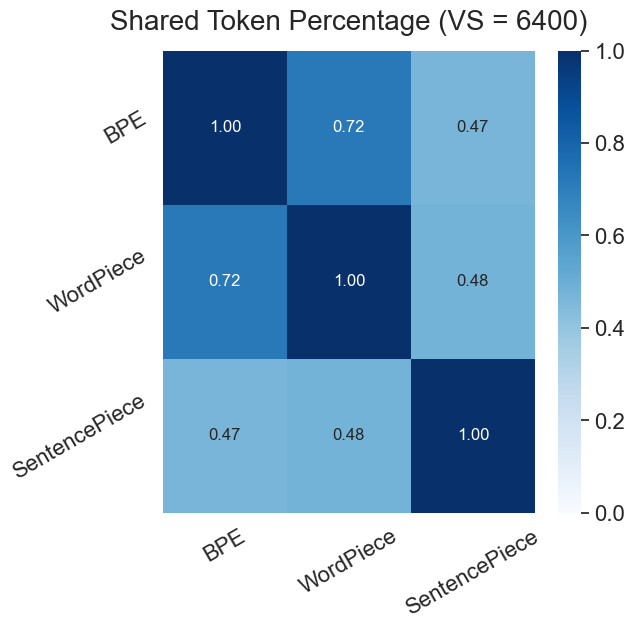

In [50]:
vocab_size = 6400
comp_tokenizers_list = [f'bpe_pt_{vocab_size}', f'wp_pt_{vocab_size}', f'spm_pt_{vocab_size}']
comp_labels = list(methods2namesPT.values())

data = np.array(np.zeros((3,3)))
for i in range(len(comp_tokenizers_list)):
    for j in range(i, len(comp_tokenizers_list)):
        data[i][j] = len(set(vocab_list[comp_tokenizers_list[i]]).intersection(set(vocab_list[comp_tokenizers_list[j]])))
        data[i][j] /= min(len(vocab_list[comp_tokenizers_list[i]]), len(vocab_list[comp_tokenizers_list[j]]))
        data[j][i] = data[i][j]
# data = data.astype(int)

fig,ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)

sns.heatmap(data, annot = True, fmt='.2f', xticklabels=comp_labels, yticklabels=comp_labels, vmax=1, vmin=0, cmap='Blues')
plt.yticks(rotation=30)
plt.xticks(rotation=30)

plt.title(f"Shared Token Percentage (VS = {vocab_size})", pad=title_pad)

# plt.savefig(f'{figures_folder_name}/shared_token_percent_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/shared_token_percent_{vocab_size}.png', bbox_inches='tight')
plt.show()

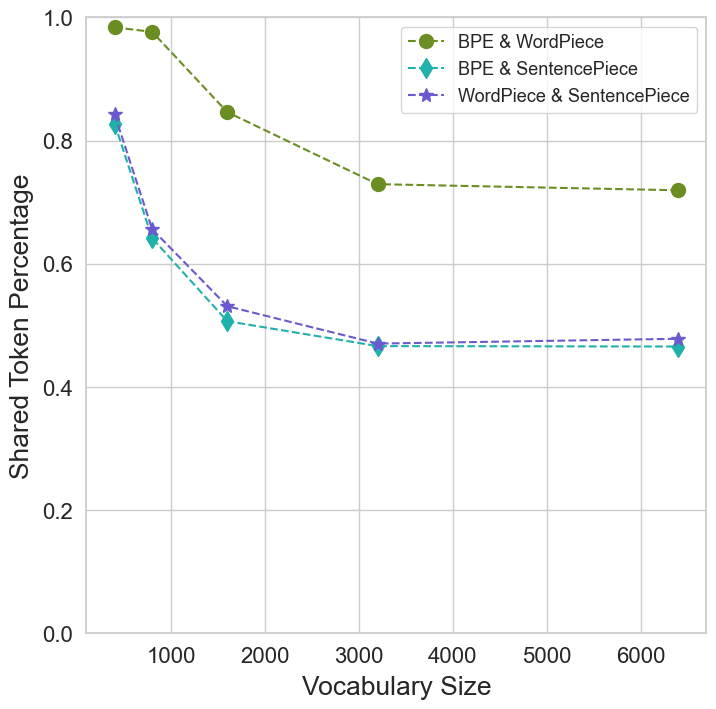

In [51]:
sns.set_style("whitegrid")
for i, (method1, method2) in enumerate([('bpe_pt', 'wp_pt'), ('bpe_pt', 'spm_pt'), ('wp_pt', 'spm_pt')]):
    shared_token_percs = []
    for vocab_size in vocab_sizes:
        tokenizer1 = f'{method1}_{vocab_size}'
        tokenizer2 = f'{method2}_{vocab_size}'
        shared_token_percs.append(len(set(vocab_list[tokenizer1]).intersection(set(vocab_list[tokenizer2]))))
        shared_token_percs[-1] /= min(len(vocab_list[tokenizer1]), len(vocab_list[tokenizer2]))
    plt.plot(vocab_sizes, shared_token_percs, markers[i], color=colors[i], markersize=10, label=f'{methods2namesPT[method1]} & {methods2namesPT[method2]}')


# plt.title(f"Shared Token Percentage Change of Vocab Sizes Between BPE and WordPiece", pad=title_pad, size=13)
plt.legend()
plt.ylim(top=1, bottom=0)
plt.xticks()
plt.yticks()
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Shared Token Percentage", labelpad=label_pad);
# plt.savefig(f'{figures_folder_name}/shared_token_percent_plot.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/shared_token_percent_plot.png', bbox_inches='tight')
plt.show()

## Token Length Distribution

Token length distribution reflects the granularity of the segmentation.

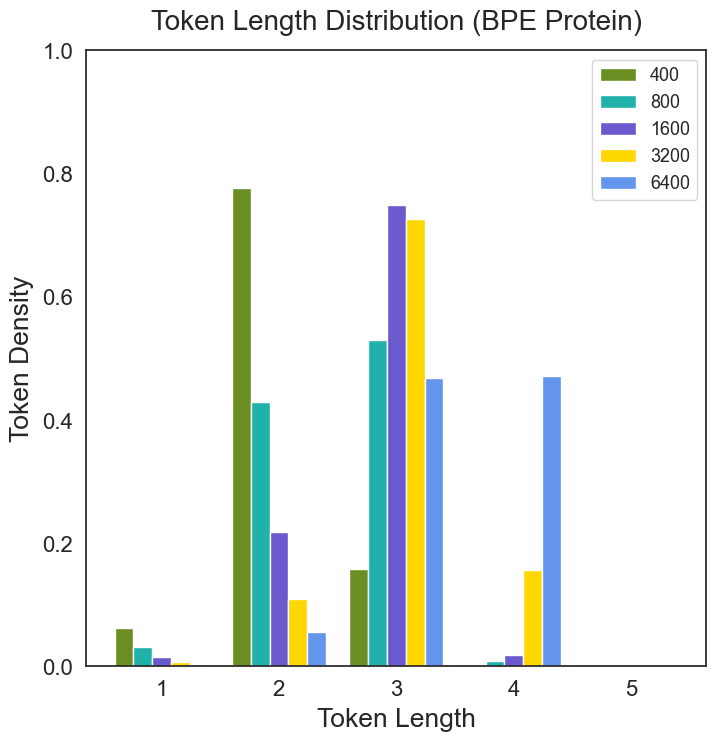

In [74]:
sns.set_style("white")

method = methods[0]
comp_tokenizers_list = [f"{method}_{vocab_size}" for vocab_size in vocab_sizes]

a = plt.hist([[len(token) for token in vocab_list[name]] for name in comp_tokenizers_list], [0.5,1.5,2.5,3.5,4.5,5.5], histtype='bar', label=vocab_sizes, density=True, color=colors)

plt.title(f"Token Length Distribution ({methods2names[method]})", pad=title_pad)
plt.xlabel("Token Length", labelpad=label_pad)
plt.ylabel("Token Density", labelpad=label_pad)
plt.ylim((0,1))
plt.legend()
# plt.savefig(f'{figures_folder_name}/token_length_dist_{method}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/token_length_dist_{method}.png', bbox_inches='tight')
plt.show()

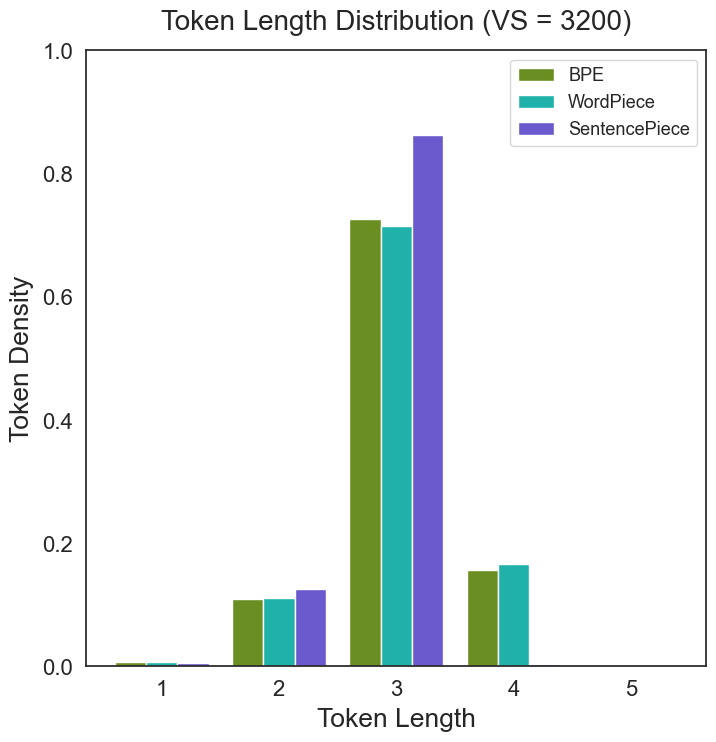

In [75]:
sns.set_style("white")

vocab_size = vocab_sizes[3]
comp_tokenizers_list = [f"{method}_{vocab_size}" for method in methods[:-1]]
comp_labels_list = [methods2namesPT[method] for method in methods[:-1]]

plt.hist([[len(token) for token in vocab_list[name]] for name in comp_tokenizers_list], [0.5,1.5,2.5,3.5,4.5,5.5], histtype='bar', label=comp_labels_list, density=True, color=colors[:3])

plt.title(f"Token Length Distribution (VS = {vocab_size})", pad=title_pad)
plt.xlabel("Token Length", labelpad=label_pad)
plt.ylabel("Token Density", labelpad=label_pad)
plt.ylim((0,1))
plt.legend()
# plt.savefig(f'{figures_folder_name}/token_length_dist_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/token_length_dist_{vocab_size}.png', bbox_inches='tight')
plt.show()

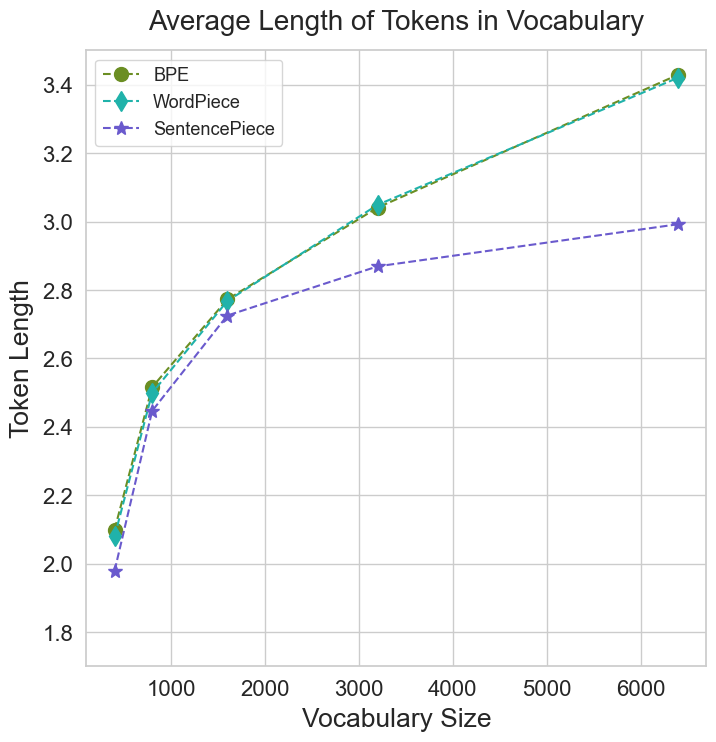

In [76]:
sns.set_style("whitegrid")
for i, method in enumerate(methods[:-1]):
    plt.plot(vocab_sizes, [np.mean([len(token) for token in vocab_list[f'{method}_{vocab_size}']]) for vocab_size in vocab_sizes], markers[i], color=colors[i], markersize=10, label=methods2namesPT[method])

plt.title(f"Average Length of Tokens in Vocabulary", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Token Length", labelpad=label_pad)
plt.legend()

# plt.xlim([0, 2000])
plt.ylim([1.7, 3.5])

# plt.savefig(f'{figures_folder_name}/token_length_plot.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/token_length_plot.png', bbox_inches='tight')

plt.show()

In [77]:
{name: np.mean([len(token) for token in vocab]) for name, vocab in vocab_list.items()}

{'bpe_pt_400': 2.1,
 'bpe_pt_800': 2.51625,
 'bpe_pt_1600': 2.7725,
 'bpe_pt_3200': 3.0409375,
 'bpe_pt_6400': 3.42921875,
 'wp_pt_400': 2.08,
 'wp_pt_800': 2.4993514915693904,
 'wp_pt_1600': 2.767857142857143,
 'wp_pt_3200': 3.048966613672496,
 'wp_pt_6400': 3.4205830810896924,
 'spm_pt_400': 1.9797468354430379,
 'spm_pt_800': 2.446835443037975,
 'spm_pt_1600': 2.72544080604534,
 'spm_pt_3200': 2.8692235146180445,
 'spm_pt_6400': 2.9923125196109193,
 'bpe_en_400': 2.3609022556390977,
 'bpe_en_800': 2.9874843554443054,
 'bpe_en_1600': 3.6497811131957474,
 'bpe_en_3200': 4.316036261331666,
 'bpe_en_6400': 4.88310673542741}

In [78]:
test_average_token_lenghts = {name: np.mean(test_protein_df[name].apply(lambda xx: np.mean([len(x) for x in xx]))) for name in list(vocab_list.keys())[:-5]}

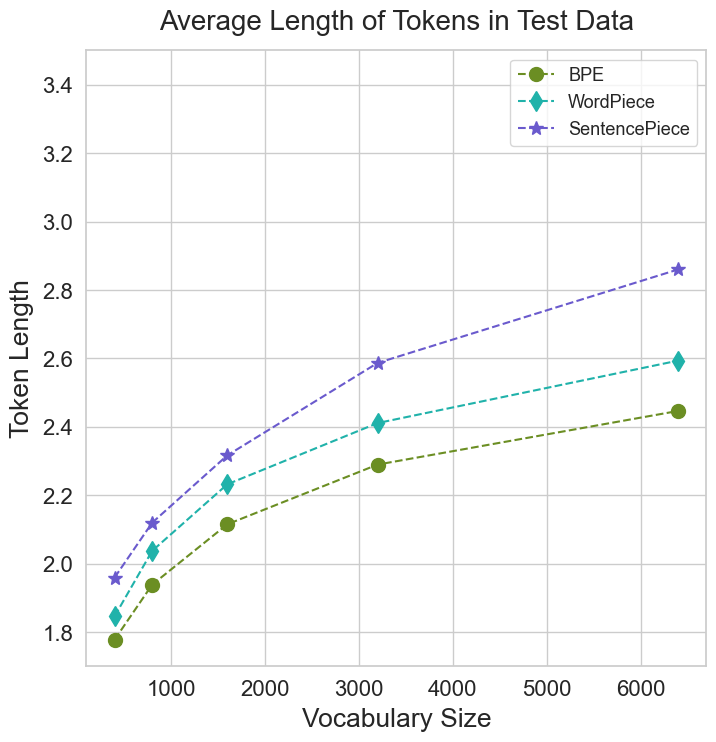

In [79]:
sns.set_style("whitegrid")

for i, method in enumerate(methods[:-1]):
    plt.plot(vocab_sizes, [test_average_token_lenghts[f'{method}_{vocab_size}'] for vocab_size in vocab_sizes], markers[i], color=colors[i], markersize=10, label=methods2namesPT[method])

plt.title(f"Average Length of Tokens in Test Data", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Token Length", labelpad=label_pad)
plt.legend()

plt.ylim([1.7, 3.5])

# plt.savefig(f'{figures_folder_name}/token_length_test_plot.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/token_length_test_plot.png', bbox_inches='tight')

plt.show()

In [80]:
{name: np.mean(test_protein_df[name].apply(lambda xx: np.mean([len(x) for x in xx]))) for name in list(vocab_list.keys())[:-5]}

{'bpe_pt_400': 1.7783874503510806,
 'bpe_pt_800': 1.9389470090316323,
 'bpe_pt_1600': 2.115448001189376,
 'bpe_pt_3200': 2.289925704598839,
 'bpe_pt_6400': 2.4467330862666645,
 'wp_pt_400': 1.8466145436120793,
 'wp_pt_800': 2.037724596777092,
 'wp_pt_1600': 2.2323592195883224,
 'wp_pt_3200': 2.411261591414531,
 'wp_pt_6400': 2.593791059145012,
 'spm_pt_400': 1.9598330060881959,
 'spm_pt_800': 2.120089568517406,
 'spm_pt_1600': 2.3169025961822434,
 'spm_pt_3200': 2.586923486118899,
 'spm_pt_6400': 2.860207590056508}

In [81]:
{name: np.mean(test_wiki_df[name].apply(lambda xx: np.mean([len(x) for x in xx]))) for name in list(vocab_list.keys())[-5:]}

{'bpe_en_400': 1.8739384383187587,
 'bpe_en_800': 2.163690170418197,
 'bpe_en_1600': 2.510541863899824,
 'bpe_en_3200': 2.883634644834318,
 'bpe_en_6400': 3.3024942678060305}

## Fertility

Fertility, the average number of tokens required to represent a protein sequence, indicates encoding efficiency.

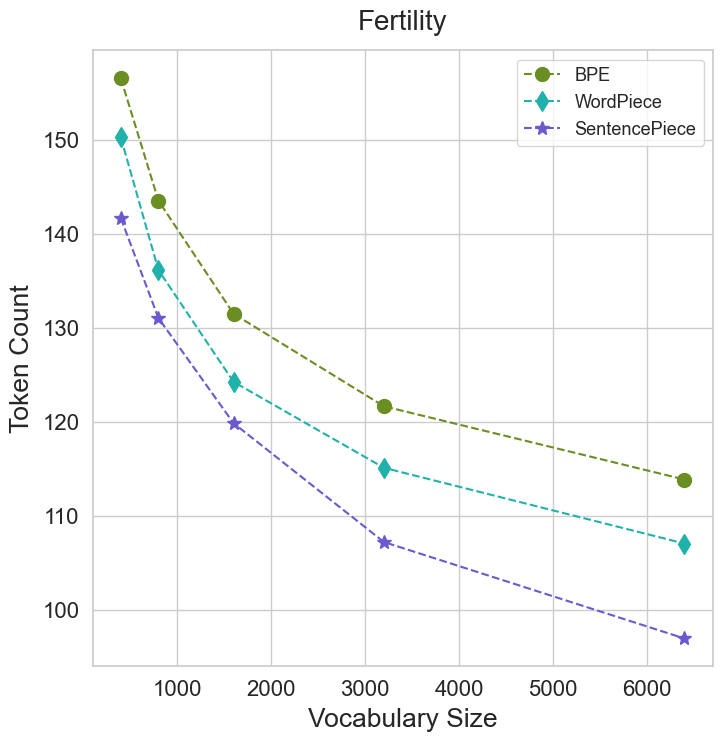

In [82]:
sns.set_style("whitegrid")
for i, method in enumerate(methods[:-1]):
    if 'pt' in method:
        test_df = test_protein_df.copy()
    else:
        test_df = test_wiki_df.copy()
    plt.plot(vocab_sizes, [test_df[f'{method}_{vocab_size}'].apply(len).mean() for vocab_size in vocab_sizes], markers[i], color=colors[i], markersize=10, label=methods2namesPT[method])

plt.title(f"Fertility", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Token Count", labelpad=label_pad)
plt.legend()

# plt.savefig(f'{figures_folder_name}/fertility_plot.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/fertility_plot.png', bbox_inches='tight')

plt.show()

## Contextual Exponence

Contextual exponence, the diversity of neighboring tokens each token encounters, sheds light on semantic relationships.

In [83]:
token_neighs = {}

window_size = 2
for name in tqdm(vocab_list.keys()):
    temp_neighs = {}
    if 'pt' in name:
        test_df = test_protein_df.copy()
    else:
        test_df = test_wiki_df.copy()
    for seq in test_df[name]:
        for i, tok in enumerate(seq):
            if tok not in temp_neighs:
                temp_neighs[tok] = []
            temp_neighs[tok].extend(seq[max(i-window_size, 0):i])
            temp_neighs[tok].extend(seq[i+1:min(i+window_size+1, len(seq))])
    token_neighs[name] = temp_neighs
    
token_neighs_unq_len = {name: {token: len(set(neighs)) for token, neighs in tokens.items()} for name, tokens in token_neighs.items()}

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.52s/it]


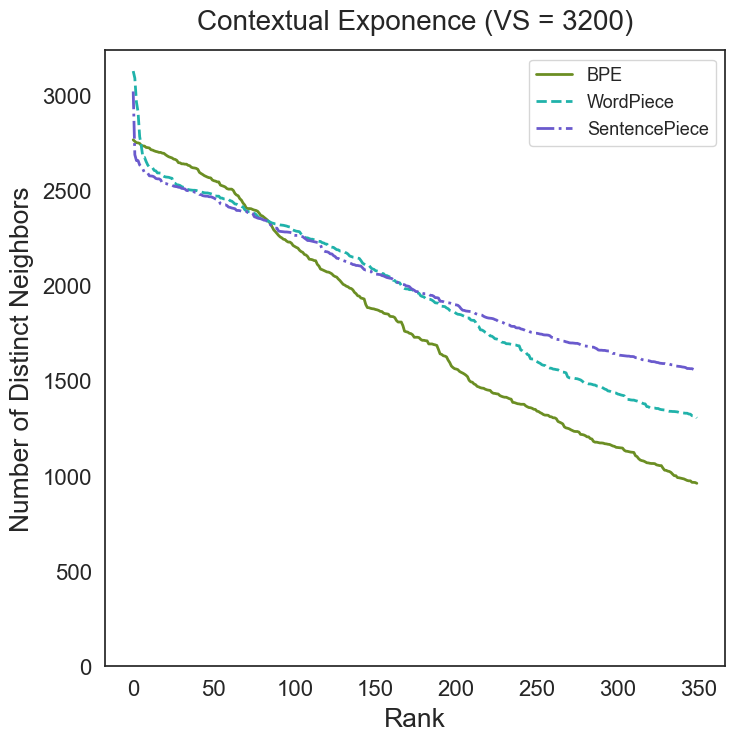

In [84]:
sns.set_style("white")
vocab_size = vocab_sizes[3]

for idx, method in enumerate(methods[:-1]):
    plt.plot([t[1] for t in sorted(token_neighs_unq_len[f'{method}_{vocab_size}'].items(), key=lambda x: -x[1])[:350]], linestyles[idx], linewidth=2, color=colors[idx], label=methods2namesPT[method])

plt.title(f"Contextual Exponence (VS = {vocab_size})", pad=title_pad)
plt.xlabel("Rank", labelpad=label_pad)
plt.ylabel("Number of Distinct Neighbors", labelpad=label_pad)
plt.ylim(0)
# plt.xlim(right = 450)
plt.legend()

# plt.savefig(f'{figures_folder_name}/contextual_exponence_plot_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/contextual_exponence_plot_{vocab_size}.png', bbox_inches='tight')

plt.show()

## Zipf's Law

Zipf's law, the inverse proportionality between token frequency and rank, indicates linguistic regularity.

In [86]:
token_freqs_dict = {}
for tokenizer_name in tqdm(vocab_list.keys()):
    if 'pt' in tokenizer_name:
        test_df = test_protein_df.copy()
    else:
        test_df = test_wiki_df.copy()
    token_freqs_dict[tokenizer_name] = test_df[tokenizer_name].apply(Counter).sum().copy()

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [03:10<00:00,  9.54s/it]


In [87]:
for tokenizer_name in tqdm(vocab_list.keys()):
    to_del = []
    for k, v in token_freqs_dict[tokenizer_name].items():
        if k not in vocab_list[tokenizer_name]:
            to_del.append(k)
    for k in to_del:
        del token_freqs_dict[tokenizer_name][k]

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.01it/s]


In [88]:
zipf_slopes = {}
for tokenizer_name, token_freqs in token_freqs_dict.items():
    freqs = np.array(list(token_freqs.values()))
    sorted_freqs = np.sort(freqs)[::-1]
    y_data = np.log(sorted_freqs)
    x_data = np.log(np.array(range(1, len(sorted_freqs) + 1)))
    
    x_masked = x_data.copy()
    y_masked = y_data.copy()
    
    zipf_slopes[tokenizer_name] = linregress(x_masked, y_masked).slope

In [89]:
zipf_slopes

{'bpe_pt_400': -1.0430469021579705,
 'bpe_pt_800': -1.1465360815613486,
 'bpe_pt_1600': -1.1278102976171822,
 'bpe_pt_3200': -1.1571231056757978,
 'bpe_pt_6400': -1.1963725455031275,
 'wp_pt_400': -0.7700774922309049,
 'wp_pt_800': -0.9369427132843164,
 'wp_pt_1600': -0.939500775131856,
 'wp_pt_3200': -1.008572264085461,
 'wp_pt_6400': -1.0738982719813237,
 'spm_pt_400': -0.6171789918009052,
 'spm_pt_800': -0.9319480658998788,
 'spm_pt_1600': -0.8895555329924415,
 'spm_pt_3200': -0.7061396034759575,
 'spm_pt_6400': -0.6743617731162114,
 'bpe_en_400': -1.1075271571245908,
 'bpe_en_800': -1.0940269724385825,
 'bpe_en_1600': -1.0813791735678908,
 'bpe_en_3200': -1.0997392920267774,
 'bpe_en_6400': -1.134940634293497}

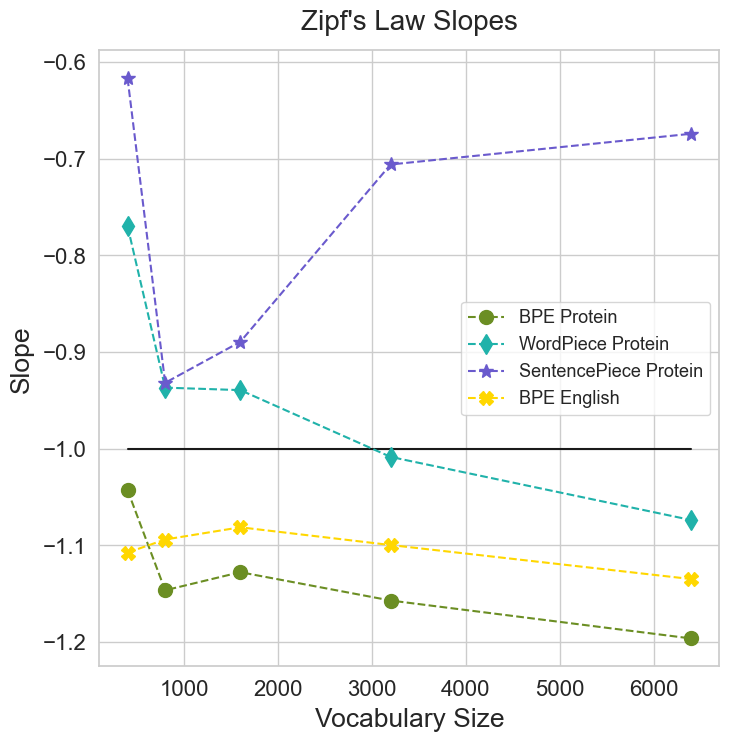

In [90]:
sns.set_style("whitegrid")

plt.plot(vocab_sizes, [-1 for _ in vocab_sizes], 'k-')

for i, method in enumerate(methods):
    plt.plot(vocab_sizes, [zipf_slopes[f'{method}_{vocab_size}'] for vocab_size in vocab_sizes], markers[i], color=colors[i], markersize=10, label=methods2names[method])

plt.title(f"Zipf's Law Slopes", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Slope", labelpad=label_pad)
plt.legend()

# plt.savefig(f'{figures_folder_name}/zipf_slope_plot.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/zipf_slope_plot.png', bbox_inches='tight')

plt.show()

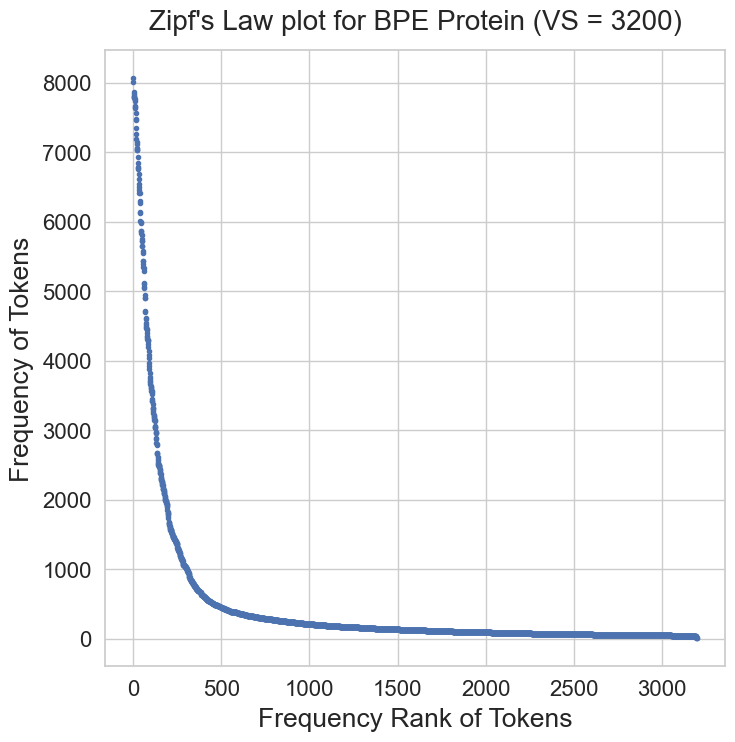

In [202]:
sns.set_style("whitegrid")
vocab_size = vocab_sizes[3]
i = 0
method = methods[i]
tokenizer_name = f'{method}_{vocab_size}'
token_freqs = token_freqs_dict[tokenizer_name]

freqs = np.array(list(token_freqs.values()))
sorted_freqs = np.sort(freqs)[::-1]

y_data = sorted_freqs
x_data = np.array(range(1, len(sorted_freqs) + 1))

plt.plot(x_data, y_data, ".")
plt.title(f"Zipf's Law plot for {methods2names[method]} (VS = {vocab_size})", pad=title_pad)
# plt.xlim([-100, 3000])
plt.xlabel("Frequency Rank of Tokens", labelpad=label_pad)
plt.ylabel("Frequency of Tokens", labelpad=label_pad)
# plt.savefig(f'{figures_folder_name}/zipf_{tokenizer_name}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/zipf_{tokenizer_name}.png', bbox_inches='tight')
plt.show()

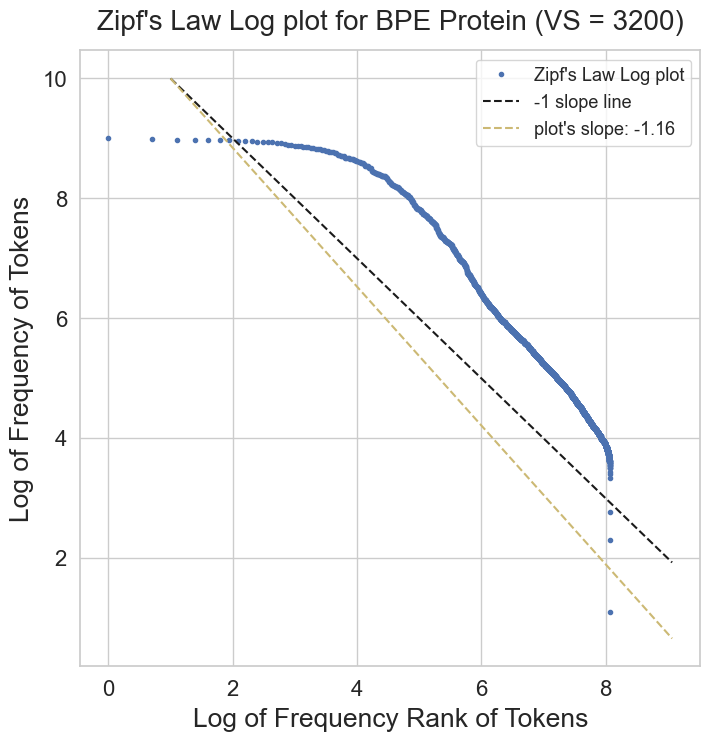

In [203]:
y_data = np.log(sorted_freqs)
x_data = np.log(np.array(range(1, len(sorted_freqs) + 1)))

x_masked = x_data.copy()
y_masked = y_data.copy()

slope = linregress(x_masked, y_masked).slope

plt.plot(x_data, y_data, ".", label="Zipf's Law Log plot")
plt.plot(x_data+1, -1*x_data+y_data[0]+1, "--", color='k', label="-1 slope line")
plt.plot(x_data+1, slope*x_data+y_data[0]-slope*x_data[0]+1, "--", color='y', label=f"plot's slope: {slope:.2f}")
plt.title(f"Zipf's Law Log plot for {methods2names[method]} (VS = {vocab_size})", pad=title_pad)
plt.xlabel("Log of Frequency Rank of Tokens", labelpad=label_pad)
plt.ylabel("Log of Frequency of Tokens", labelpad=label_pad)
plt.legend()
# plt.savefig(f'{figures_folder_name}/zipf_log_{tokenizer_name}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/zipf_log_{tokenizer_name}.png', bbox_inches='tight')
plt.show()

## Brevity Law

Brevity law is the tendency of frequently used tokens to be shorter.

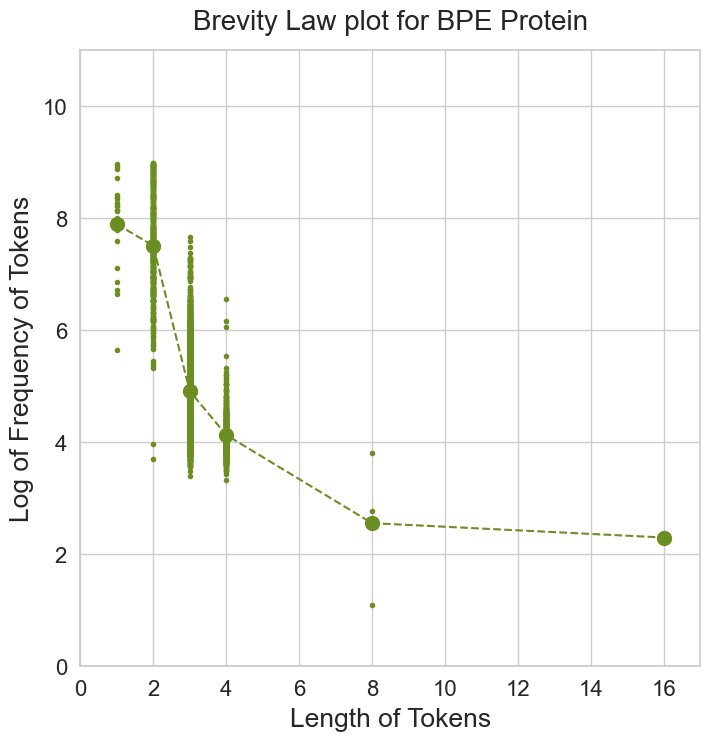

In [93]:
sns.set_style("whitegrid")
vocab_size = 3200
i = 0
method = methods[i]
tokenizer_name = f'{method}_{vocab_size}'
token_freqs = token_freqs_dict[tokenizer_name]

freqs = np.log(np.array(list(token_freqs.values())))
lengths = np.array([len(token) for token in list(token_freqs.keys())])

plt.plot(lengths, freqs, ".", color=colors[i])

lf_df = pd.DataFrame([lengths, freqs]).T
lf_df = lf_df.rename(columns={0:'lengths', 1:'freqs'})
lf_df['lengths'] = lf_df['lengths'].astype(int)
lf_mean = lf_df.groupby('lengths')['freqs'].mean()
plt.plot(lf_mean.index, lf_mean, markers[0], markersize=10, color=colors[i])

plt.title(f"Brevity Law plot for {methods2names[method]}", pad=title_pad)
plt.ylim(bottom=0, top=11)
plt.xlim(left=0, right=17)
plt.xlabel("Length of Tokens", labelpad=label_pad)
plt.ylabel("Log of Frequency of Tokens", labelpad=label_pad)
# plt.savefig(f'{figures_folder_name}/brevity_{tokenizer_name}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/brevity_{tokenizer_name}.png', bbox_inches='tight')
plt.show()

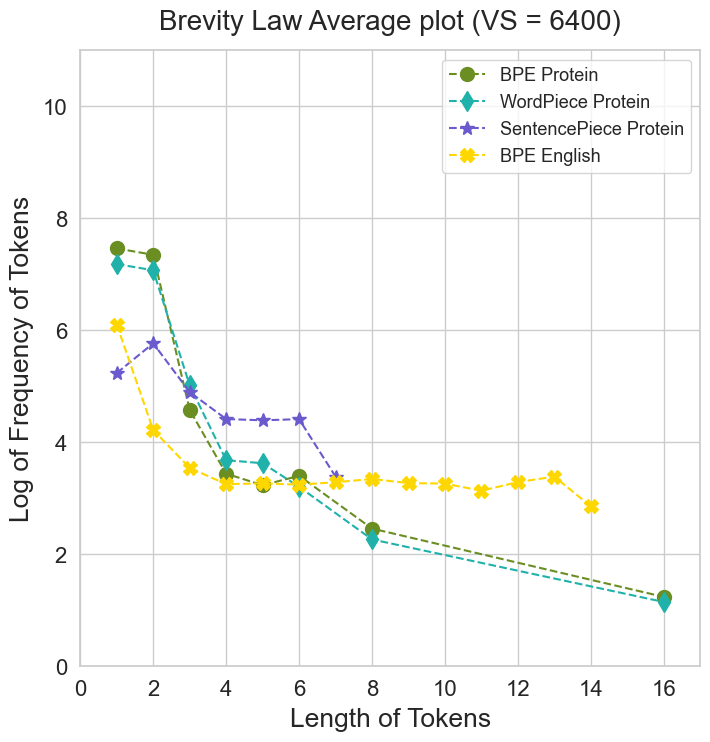

In [183]:
vocab_size = vocab_sizes[4]
for idx, method in enumerate(methods):
    tokenizer_name = f'{method}_{vocab_size}'
    token_freqs = token_freqs_dict[tokenizer_name]

    freqs = np.log(np.array(list(token_freqs.values())))
    lengths = np.array([len(token) for token in list(token_freqs.keys())])

    lf_df = pd.DataFrame([lengths, freqs]).T
    lf_df = lf_df.rename(columns={0:'lengths', 1:'freqs'})
    lf_df['lengths'] = lf_df['lengths'].astype(int)
    lf_mean = lf_df.groupby('lengths')['freqs'].mean()
    lf_mean = lf_mean[lf_mean.index < 20]
    plt.plot(lf_mean.index, lf_mean, markers[idx], color=colors[idx], markersize=10, label=methods2names[method])

plt.title(f"Brevity Law Average plot (VS = {vocab_size})", pad=title_pad)
plt.ylim(bottom=0, top=11)
plt.xlim(left=0, right=17)
plt.xlabel("Length of Tokens", labelpad=label_pad)
plt.ylabel("Log of Frequency of Tokens", labelpad=label_pad)
plt.legend()
# plt.savefig(f'{figures_folder_name}/brevity_avg_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/brevity_avg_{vocab_size}.png', bbox_inches='tight')
plt.show()

## Heap's Law

Heaps' law states that the growth of vocabulary size increases with dataset size but at a decreasing rate.

In [96]:
np.random.seed(10)
heaps_dict = {}
test_protein_df_permutation = np.random.permutation(len(test_protein_df))
test_wiki_df_permutation = np.random.permutation(len(test_wiki_df))

for tokenizer_name in tqdm(tokenizer_list.keys()):
    tokens_set = set()
    unique_tokens_count = [0]
    all_tokens_count = [0]
    if 'pt' in tokenizer_name:
        test_df = test_protein_df.copy()
        test_df_permutation = test_protein_df_permutation.copy()
    else:
        test_df = test_wiki_df.copy()
        test_df_permutation = test_wiki_df_permutation.copy()
    for i in test_df_permutation:
        tokens_set = tokens_set.union(test_df[tokenizer_name].iloc[i])
        unique_tokens_count.append(len(tokens_set))
        all_tokens_count.append(all_tokens_count[-1]+len(test_df[tokenizer_name].iloc[i]))
    heaps_dict[tokenizer_name] = (unique_tokens_count, all_tokens_count)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.13it/s]


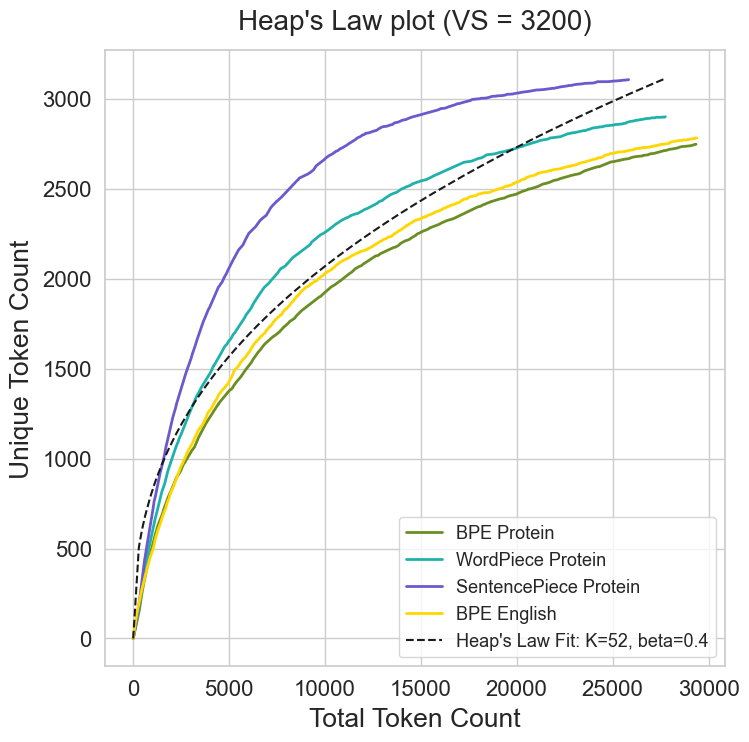

In [97]:
sns.set_style("whitegrid")
vocab_size = vocab_sizes[3]

max_index = 0
for method in methods[:-1]:
    tokenizer_name = f'{method}_{vocab_size}'
    pareto_max = int(heaps_dict[tokenizer_name][0][-1]*.8)
    for i, cnt in enumerate(heaps_dict[tokenizer_name][0]):
        if cnt >= pareto_max:
            if i > max_index:
                max_index = i
            break

for i, method in enumerate(methods):
    tokenizer_name = f'{method}_{vocab_size}'
    if 'pt' in tokenizer_name:
        y_data = heaps_dict[tokenizer_name][0][:max_index+vocab_size//50]
        x_data = heaps_dict[tokenizer_name][1][:max_index+vocab_size//50]
    else:
        y_data = np.array(heaps_dict[tokenizer_name][0])[np.array(heaps_dict[tokenizer_name][1]) < heaps_dict[f'bpe_pt_{vocab_size}'][1][max_index+vocab_size//50]]
        x_data = np.array(heaps_dict[tokenizer_name][1])[np.array(heaps_dict[tokenizer_name][1]) < heaps_dict[f'bpe_pt_{vocab_size}'][1][max_index+vocab_size//50]]
    plt.plot(x_data, y_data, '-', linewidth=2, color=colors[i], label=methods2names[method])
    
K = 52
beta = 0.4

x_data = heaps_dict[f'wp_pt_{vocab_size}'][1][:max_index+vocab_size//50]
plt.plot(x_data, K*np.array(x_data)**beta, "--k", linewidth=1.5, label=f"Heap's Law Fit: K={K}, beta={beta}")

plt.title(f"Heap's Law plot (VS = {vocab_size})", pad=title_pad)
# plt.xlim([0, 400000])
# plt.ylim([0, 10500])
plt.xlabel("Total Token Count", labelpad=label_pad)
plt.ylabel("Unique Token Count", labelpad=label_pad)
plt.legend()
# plt.savefig(f'{figures_folder_name}/heap_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/heap_{vocab_size}.png', bbox_inches='tight')
plt.show()

## Menzerath's Law

Menzerath's law shows the inverse relationship between a protein sequence's length and its tokens' length.

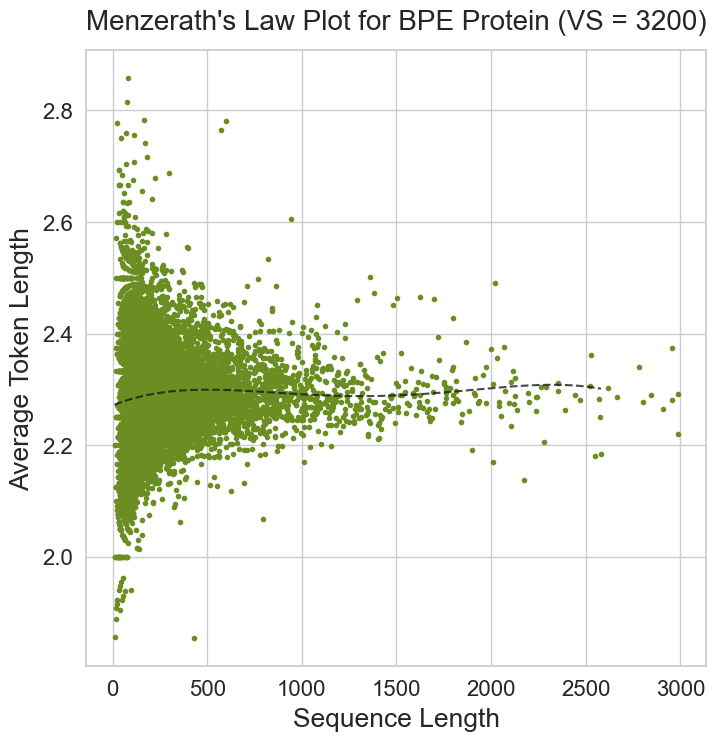

In [262]:
sns.set_style("whitegrid")
vocab_size = vocab_sizes[3]
i = 0
method = methods[i]
if 'pt' in method:
    test_df = test_protein_df.copy()
else:
    test_df = test_wiki_df.copy()
    
seq_lengths = test_df['text'].apply(len)
avg_token_lengths = test_df[f'{method}_{vocab_size}'].apply(lambda tokens: np.mean([len(token) for token in tokens]))
plt.plot(seq_lengths, avg_token_lengths, ".", color=colors[i], label=f'{method}')

seq_lengths = test_df['text'].apply(len)
avg_token_lengths = test_df[f'{method}_{vocab_size}'].apply(lambda tokens: np.mean([len(token) for token in tokens]))
coefficients = np.polyfit(seq_lengths, avg_token_lengths, 4)
p = np.poly1d(coefficients)
y_fit = p(sorted(list(set(seq_lengths))))
plt.plot(sorted(list(set(seq_lengths)))[:-10], y_fit[:-10], '--k', alpha=.8)

plt.title(f"Menzerath's Law Plot for {methods2names[method]} (VS = {vocab_size})", pad=title_pad)
# plt.xlim([-125, 3125])
# plt.ylim([1.7,3.3])
plt.xlabel("Sequence Length", labelpad=label_pad)
plt.ylabel("Average Token Length", labelpad=label_pad)
# plt.legend()
# plt.savefig(f'{figures_folder_name}/menzerath_{method}_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/menzerath_{method}_{vocab_size}.png', bbox_inches='tight')
plt.show()

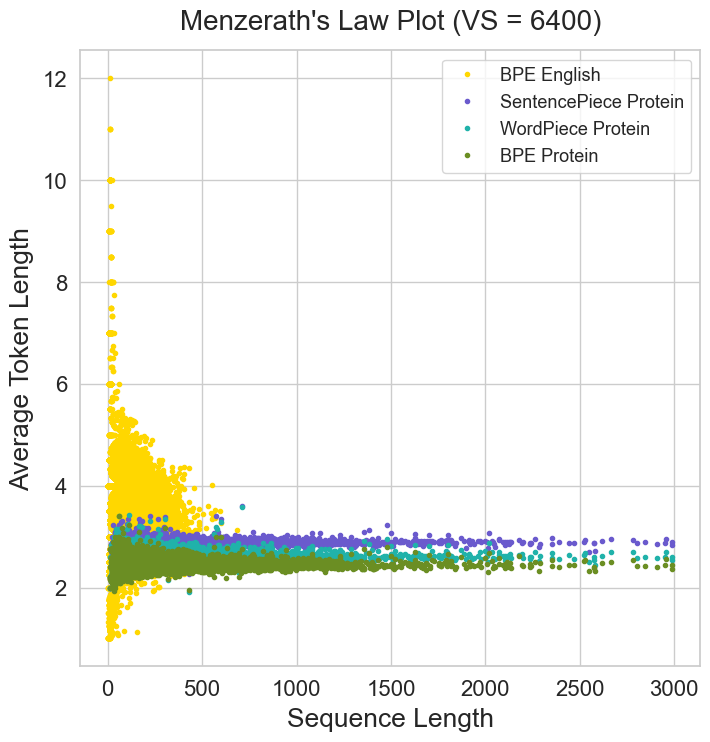

In [243]:
vocab_size = vocab_sizes[4]
for i, method in enumerate(methods[::-1]):
    if 'pt' in method:
        test_df = test_protein_df.copy()
    else:
        test_df = test_wiki_df.copy()
    seq_lengths = test_df['text'].apply(len)
    avg_token_lengths = test_df[f'{method}_{vocab_size}'].apply(lambda tokens: np.mean([len(token) for token in tokens]))
    plt.plot(seq_lengths, avg_token_lengths, ".", color=colors[::-1][-4:][i], label=f'{methods2names[method]}')#_{vocab_size}')

    
# for i, method in enumerate(methods[::-1]):
#     if 'pt' in method:
#         test_df = test_protein_df.copy()
#     else:
#         test_df = test_wiki_df.copy()
#     seq_lengths = test_df['text'].apply(len)
#     avg_token_lengths = test_df[f'{method}_{vocab_size}'].apply(lambda tokens: np.mean([len(token) for token in tokens]))
#     coefficients = np.polyfit(seq_lengths, avg_token_lengths, 4)
#     p = np.poly1d(coefficients)
#     y_fit = p(sorted(list(set(seq_lengths))))
#     plt.plot(sorted(list(set(seq_lengths))), y_fit, '--k', alpha=.8)


plt.title(f"Menzerath's Law Plot (VS = {vocab_size})", pad=title_pad)
# plt.xlim([0, 2000])
# plt.ylim([1,4])
plt.xlabel("Sequence Length", labelpad=label_pad)
plt.ylabel("Average Token Length", labelpad=label_pad)
plt.legend()
# plt.savefig(f'{figures_folder_name}/menzerath_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/menzerath_{vocab_size}.png', bbox_inches='tight')
plt.show()

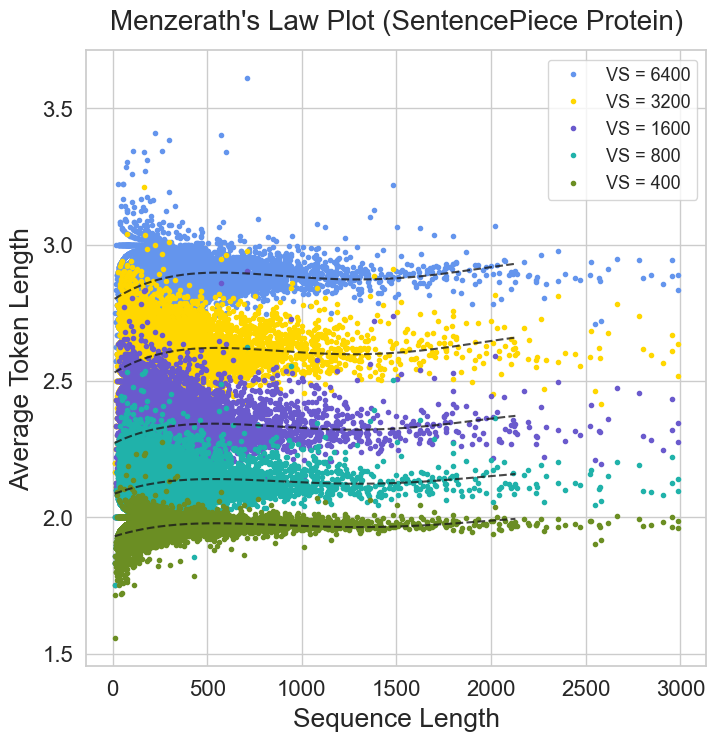

In [242]:
method = methods[-2]
if 'pt' in method:
    test_df = test_protein_df.copy()
else:
    test_df = test_wiki_df.copy()
    
for i, vocab_size in enumerate(vocab_sizes[::-1]):
    seq_lengths = test_df['text'].apply(len)
    avg_token_lengths = test_df[f'{method}_{vocab_size}'].apply(lambda tokens: np.mean([len(token) for token in tokens]))
    plt.plot(seq_lengths, avg_token_lengths, ".", color=colors[::-1][i], label=f'VS = {vocab_size}')


for i, vocab_size in enumerate(vocab_sizes[::-1]):
    seq_lengths = test_df['text'].apply(len)
    avg_token_lengths = test_df[f'{method}_{vocab_size}'].apply(lambda tokens: np.mean([len(token) for token in tokens]))
    coefficients = np.polyfit(seq_lengths, avg_token_lengths, 4)
    p = np.poly1d(coefficients)
    y_fit = p(sorted(list(set(seq_lengths))))
    plt.plot(sorted(list(set(seq_lengths)))[:-30], y_fit[:-30], '--k', alpha=.8)
    
plt.title(f"Menzerath's Law Plot ({methods2names[method]})", pad=title_pad)
# plt.xlim([0, 2000])
# plt.ylim([1, 4])
plt.xlabel("Sequence Length", labelpad=label_pad)
plt.ylabel("Average Token Length", labelpad=label_pad)
plt.legend()
# plt.savefig(f'{figures_folder_name}/menzerath_{methods2names[method]}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/menzerath_{methods2names[method]}.png', bbox_inches='tight')
plt.show()

## Protein Domain Boundary Alignment

Protein domain boundary alignment during tokenization is essential to preserving the biological meaning of the sequence.

In [101]:
def parse_protein_features(features):
    features_list = []
    
    if 'features' not in features or len(features['features']) == 0:
        feature_dict = {
            'type': "",
            'start': -1,
            'end': -1,
            'description': ""
        }
        if 'features' not in features:
            if 'entryType' not in features:
                feature_dict['type'] = "Invalid"
            elif features['entryType'] == "Inactive":
                feature_dict['type'] = "Inactive"
            else:
                feature_dict['type'] = "Empty"
        else:
            feature_dict['type'] = "Empty"
        features_list.append(feature_dict)
    else:
        for feature in features['features']:
            feature_dict = {
                'type': feature['type'],
                'start': feature['location']['start']['value'],
                'end': feature['location']['end']['value'],
                'description': feature['description']
            }
            features_list.append(feature_dict)
    return features_list

In [ ]:
test_protein_features_df['features_parsed'] = test_protein_features_df['features'].apply(parse_protein_features)

In [349]:
test_protein_features_df = test_protein_features_df.explode('features_parsed')
test_protein_features_df = pd.concat([test_protein_features_df.reset_index(drop=True), pd.DataFrame.from_dict(list(test_protein_features_df['features_parsed']))], axis=1)
test_protein_features_df = test_protein_features_df.drop(columns=['features', 'features_parsed'])

In [102]:
test_protein_features_df

,id,name,text,type,start,end,description
0,5,UniRef50_A0A819JI93,MIHYELHEQAAKELYEFEEKQQQHPIQREKYLNKKMTNFNRRDFSV...,Domain,103,441,G-protein coupled receptors family 1 profile
1,8,UniRef50_A0A1L9QV50,MFADKTLNRPIGIVFEEQVWKAPDRVAIASNNHQWTYQTLNSRANA...,Domain,512,586,Carrier
2,8,UniRef50_A0A1L9QV50,MFADKTLNRPIGIVFEEQVWKAPDRVAIASNNHQWTYQTLNSRANA...,Domain,1581,1656,Carrier
3,8,UniRef50_A0A1L9QV50,MFADKTLNRPIGIVFEEQVWKAPDRVAIASNNHQWTYQTLNSRANA...,Domain,2647,2722,Carrier
4,9,UniRef50_A0A3N5JKR9,MKKSILVFMLAAALAVLAFAAGMGQKKNPLFSKSAVQYDSSGIKLK...,Domain,344,508,P/Homo B
...,...,...,...,...,...,...,...
13221,6080,UniRef50_A0A0E9P7D0,MLGFYFCVFSHCVFSSSLS,Empty,-1,-1,
13222,6081,UniRef50_A0A553RPB3,MLCEVQHSLYREYLSLL,Empty,-1,-1,
13223,6082,UniRef50_A0A2P2R4G9,MCHYCVSHNINHMY,Empty,-1,-1,
13224,6083,UniRef50_A0A8F3CQA7,LXSLFGNDQLLQ,Empty,-1,-1,


In [103]:
tokens_cumsum_df = test_protein_df[test_protein_df.columns[3:]].applymap(lambda tokens: np.cumsum(np.array([len(x) for x in tokens])))
tokens_cumsum_df = pd.concat([test_protein_df[test_protein_df.columns[:3]], tokens_cumsum_df], axis=1)
tokens_cumsum_df = pd.merge(test_protein_features_df[test_protein_features_df['start'] != -1], tokens_cumsum_df, 'inner', ['id', 'name', 'text'])

### Boundary Detection

In [104]:
def domain_boundary_detection(row):
    return {token_col+'_boundary': (True if row['start'] == 1 else row['start']-1 in row[token_col], row['end'] in row[token_col]) for token_col in list(tokenizer_list.keys())[:-5]}

In [105]:
tokens_domain_boundary_df = pd.DataFrame.from_dict(list(tokens_cumsum_df.apply(domain_boundary_detection, axis=1)))
tokens_domain_boundary_df = pd.concat([tokens_cumsum_df[tokens_cumsum_df.columns[:7]], tokens_domain_boundary_df], axis=1)

In [106]:
tokens_domain_boundary_df

,id,name,text,type,start,end,description,bpe_pt_400_boundary,bpe_pt_800_boundary,bpe_pt_1600_boundary,...,wp_pt_400_boundary,wp_pt_800_boundary,wp_pt_1600_boundary,wp_pt_3200_boundary,wp_pt_6400_boundary,spm_pt_400_boundary,spm_pt_800_boundary,spm_pt_1600_boundary,spm_pt_3200_boundary,spm_pt_6400_boundary
0,5,UniRef50_A0A819JI93,MIHYELHEQAAKELYEFEEKQQQHPIQREKYLNKKMTNFNRRDFSV...,Domain,103,441,G-protein coupled receptors family 1 profile,"(True, True)","(False, True)","(False, True)",...,"(True, True)","(False, True)","(False, True)","(False, True)","(False, True)","(True, True)","(True, False)","(False, False)","(False, False)","(True, False)"
1,8,UniRef50_A0A1L9QV50,MFADKTLNRPIGIVFEEQVWKAPDRVAIASNNHQWTYQTLNSRANA...,Domain,512,586,Carrier,"(True, True)","(True, True)","(True, True)",...,"(True, False)","(True, True)","(True, False)","(True, False)","(True, False)","(True, False)","(False, False)","(False, False)","(False, False)","(True, True)"
2,8,UniRef50_A0A1L9QV50,MFADKTLNRPIGIVFEEQVWKAPDRVAIASNNHQWTYQTLNSRANA...,Domain,1581,1656,Carrier,"(True, True)","(True, True)","(True, True)",...,"(True, False)","(True, True)","(False, True)","(False, True)","(False, True)","(True, True)","(True, True)","(False, False)","(False, False)","(False, True)"
3,8,UniRef50_A0A1L9QV50,MFADKTLNRPIGIVFEEQVWKAPDRVAIASNNHQWTYQTLNSRANA...,Domain,2647,2722,Carrier,"(True, True)","(True, True)","(True, True)",...,"(True, False)","(True, False)","(True, True)","(True, True)","(True, True)","(False, True)","(False, False)","(False, False)","(False, False)","(False, False)"
4,9,UniRef50_A0A3N5JKR9,MKKSILVFMLAAALAVLAFAAGMGQKKNPLFSKSAVQYDSSGIKLK...,Domain,344,508,P/Homo B,"(False, False)","(False, False)","(False, False)",...,"(False, False)","(False, False)","(False, False)","(False, True)","(False, False)","(True, False)","(False, True)","(False, True)","(False, False)","(False, True)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4641,5971,UniRef50_A0A8J7REP5,AGDPDNGIAPGTAFEDLPADWVCPVCGASKDEFEAA,Domain,1,36,Rubredoxin-like,"(True, True)","(True, True)","(True, True)",...,"(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)"
4642,5977,UniRef50_A0A1I7K7D8,MPSVRRQEPLYAFMARNAVRSLNYYRIPPAQVVELGTQDEM,Domain,7,41,K+ potassium transporter C-terminal,"(True, True)","(True, True)","(False, True)",...,"(False, True)","(True, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(True, True)","(False, True)"
4643,5981,UniRef50_A0A7L9BLH2,MPTYSISLDNARQVTHKWVDDYNHKRPHQALNYQTPMAYAA,Domain,6,36,Integrase catalytic,"(False, True)","(False, True)","(False, True)",...,"(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(True, False)","(True, False)","(True, False)","(False, True)","(False, True)"
4644,6016,UniRef50_A0A969ENQ8,MKTSARNQFWGEVVQVQKGAVNAEVALRLTGGEQLTS,Domain,2,37,Mop,"(True, True)","(True, True)","(True, True)",...,"(True, True)","(False, True)","(False, True)","(False, True)","(False, True)","(True, True)","(False, True)","(False, True)","(False, True)","(False, True)"


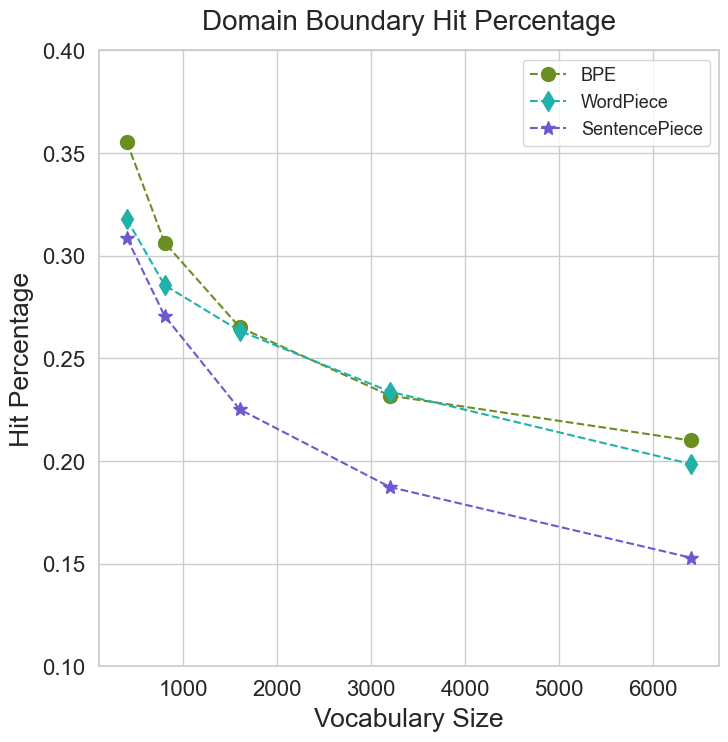

In [107]:
sns.set_style("whitegrid")
for i, method in enumerate(methods[:-1]):
    
    test_df = tokens_domain_boundary_df[tokens_domain_boundary_df['type'] == 'Domain']
    plt.plot(vocab_sizes, [test_df[f'{method}_{vocab_size}_boundary'].value_counts(normalize=True)[(True, True)] for vocab_size in vocab_sizes],
             markers[i],
             color=colors[i],
             markersize=10,
             label=methods2namesPT[method])

plt.title(f"Domain Boundary Hit Percentage", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Hit Percentage", labelpad=label_pad)
plt.legend()

# plt.xlim([0, 2000])
plt.ylim([.1, .4])

# plt.savefig(f'{figures_folder_name}/domain_boundary.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/domain_boundary.png', bbox_inches='tight')

plt.show()